# Análisis Exploratorio de Datos (EDA) - Árbol de Decisión

En este análisis, se ha utilizado un modelo de Random Forest Classifier para predecir la presencia de enfermedad cardíaca en pacientes, utilizando datos clínicos recopilados en un conjunto de datos de salud cardiovascular. A continuación, se presenta el análisis detallado del modelo, métricas de rendimiento y visualizaciones clave.

## Carga y Preparación de los Datos

El conjunto de datos se carga desde un archivo CSV llamado `heart.csv`, y contiene información médica de pacientes, como edad, presión arterial, niveles de colesterol, resultados de electrocardiogramas, entre otros.

### Codificación de Variables Categóricas

El dataset contiene variables categóricas como:
	•	Sex (M/F)
	•	ChestPainType (tipos de dolor en el pecho)
	•	RestingECG (tipo de electrocardiograma en reposo)
	•	ExerciseAngina (presencia de angina con ejercicio)
	•	ST_Slope (pendiente del segmento ST)

Estas variables han sido transformadas en variables one-hot encoded utilizando pd.get_dummies, eliminando la primera categoría para evitar colinealidad.

## Normalización

Aunque Random Forest no requiere normalización, se ha aplicado StandardScaler por consistencia metodológica y para facilitar comparaciones con otros modelos que sí lo necesitan.

## Modelado

Se ha utilizado un modelo Random Forest Classifier con los siguientes parámetros:
	•	n_estimators=100 árboles de decisión
	•	max_depth=6 para evitar sobreajuste y mantener la interpretabilidad
	•	random_state=42 para reproducibilidad

	•	Variable objetivo (y): HeartDisease (1 si hay enfermedad cardíaca, 0 si no)
	•	Variables predictoras (X): Todas las demás columnas del dataset una vez codificadas

- **Variable objetivo (y):** `HeartDisease` (1 si hay enfermedad cardíaca, 0 si no)
- **Variables predictoras (X):** Todas las demás columnas del dataset una vez codificadas

### División de los Datos

El conjunto de datos se divide en conjuntos de entrenamiento y prueba (80% para entrenamiento y 20% para prueba) para evaluar el rendimiento del modelo.

### Entrenamiento del Modelo

El modelo de Árbol de Decisión se entrena con un límite de profundidad de 6 para evitar el sobreajuste y hacer que el modelo sea más interpretable.

## Evaluación del Modelo

El rendimiento del modelo se evalúa mediante las siguientes métricas:

- **Exactitud (Accuracy):** 0.883
- **Matriz de Confusión:** La matriz muestra el número de predicciones correctas e incorrectas para cada clase (Aceptó/No Aceptó).
- **Informe de Clasificación:** Un análisis detallado que incluye métricas como precisión, recall y f1-score para cada clase.

Accuracy: 0.870
Confusion Matrix:
[[66 11]
 [13 94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

# 1. Cargar el dataset
df = pd.read_csv("heart_data_aumentado.csv")

# 2. Codificar variables categóricas (one-hot encoding)
#df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

# 3. Separar variables predictoras y objetivo
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# 4. Escalado (aunque RF no lo requiere estrictamente, lo dejamos por consistencia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. División del dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [131]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 30, 50],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=42),
                    param_grid,
                    cv=5,
                    scoring='f1_weighted',
                    n_jobs=-1)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor F1 score:", grid.best_score_)

Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 10}
Mejor F1 score: 0.9205349038459243


In [132]:
# 6. Entrenamiento con Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=8,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_samples_leaf=3,
    min_samples_split=10,
    random_state=42
)
# rf_model = RandomForestClassifier(
#     n_estimators=200,        # Aumentamos el número de árboles para estabilidad
#     max_depth=8,             # Profundidad moderada: ni muy superficial ni sobreajustada
#     min_samples_split=5,     # Requiere más muestras para dividir un nodo → menos overfitting
#     min_samples_leaf=3,      # Evita hojas con muy pocos ejemplos
#     max_features='sqrt',     # Opción clásica en clasificación → buen trade-off entre bias/varianza
#     max_leaf_nodes=30,       # Limita el crecimiento arbitrario del árbol
#     class_weight='balanced', # Ayuda en caso de leve desbalance (107 vs 77)
#     random_state=42          # Reproducibilidad
# )

In [133]:
rf_model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.934
Confusion Matrix:
[[355  31]
 [ 21 377]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       386
           1       0.92      0.95      0.94       398

    accuracy                           0.93       784
   macro avg       0.93      0.93      0.93       784
weighted avg       0.93      0.93      0.93       784



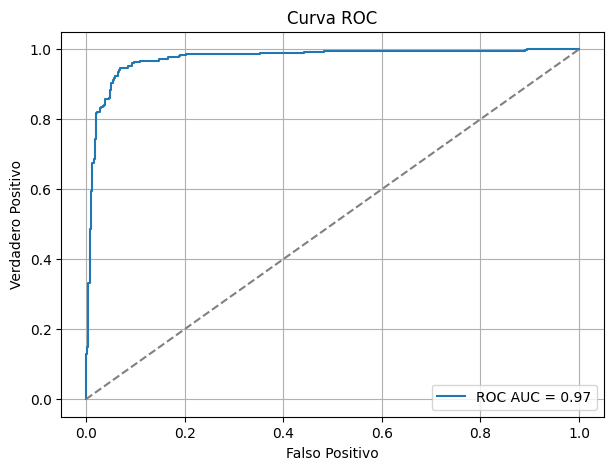

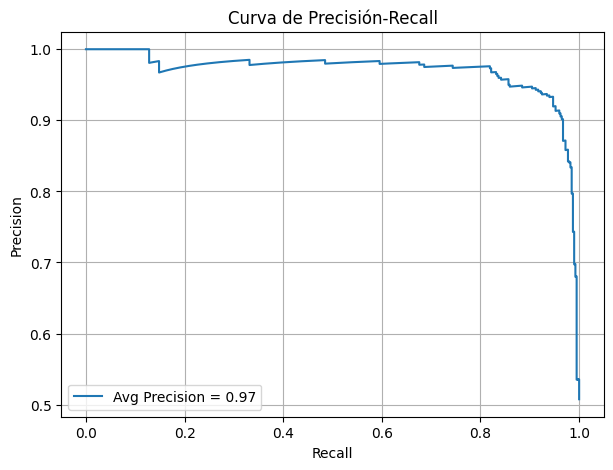

In [134]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('Curva ROC')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.legend()
plt.grid()
plt.show()

# Curva de precisión-recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'Avg Precision = {average_precision_score(y_test, y_proba):.2f}')
plt.title('Curva de Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

/var/folders/by/_c0phsdn6xl_85fftg8cd8480000gn/T/ipykernel_75916/3980081957.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=feature_importances, palette='magma')


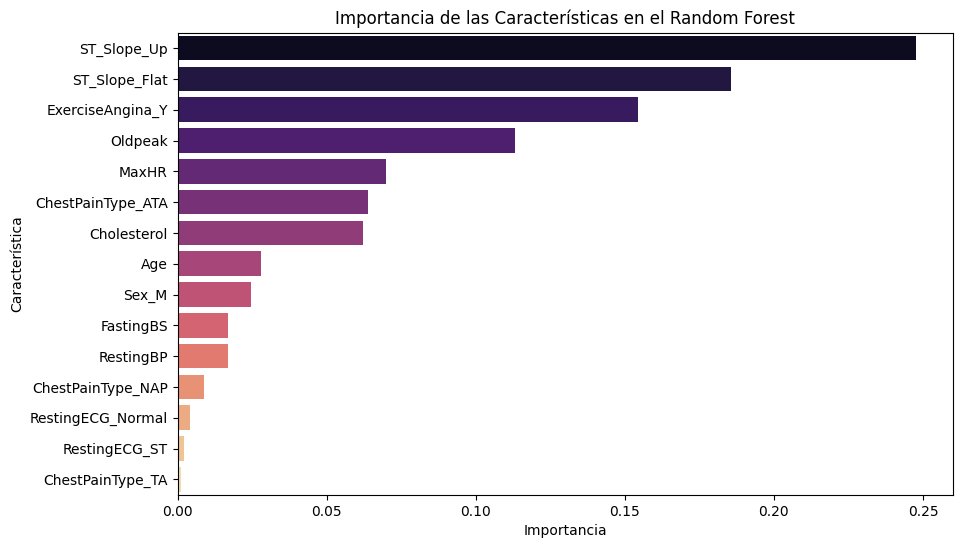

In [135]:
# 8. Importancia de características
# 8. Importancia de características (corrigiendo la fuente de nombres de columnas)
feature_importances = pd.DataFrame({
    'Característica': X.columns,  # X viene de df sin HeartDisease
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=feature_importances, palette='magma')
plt.title('Importancia de las Características en el Random Forest')
plt.show()

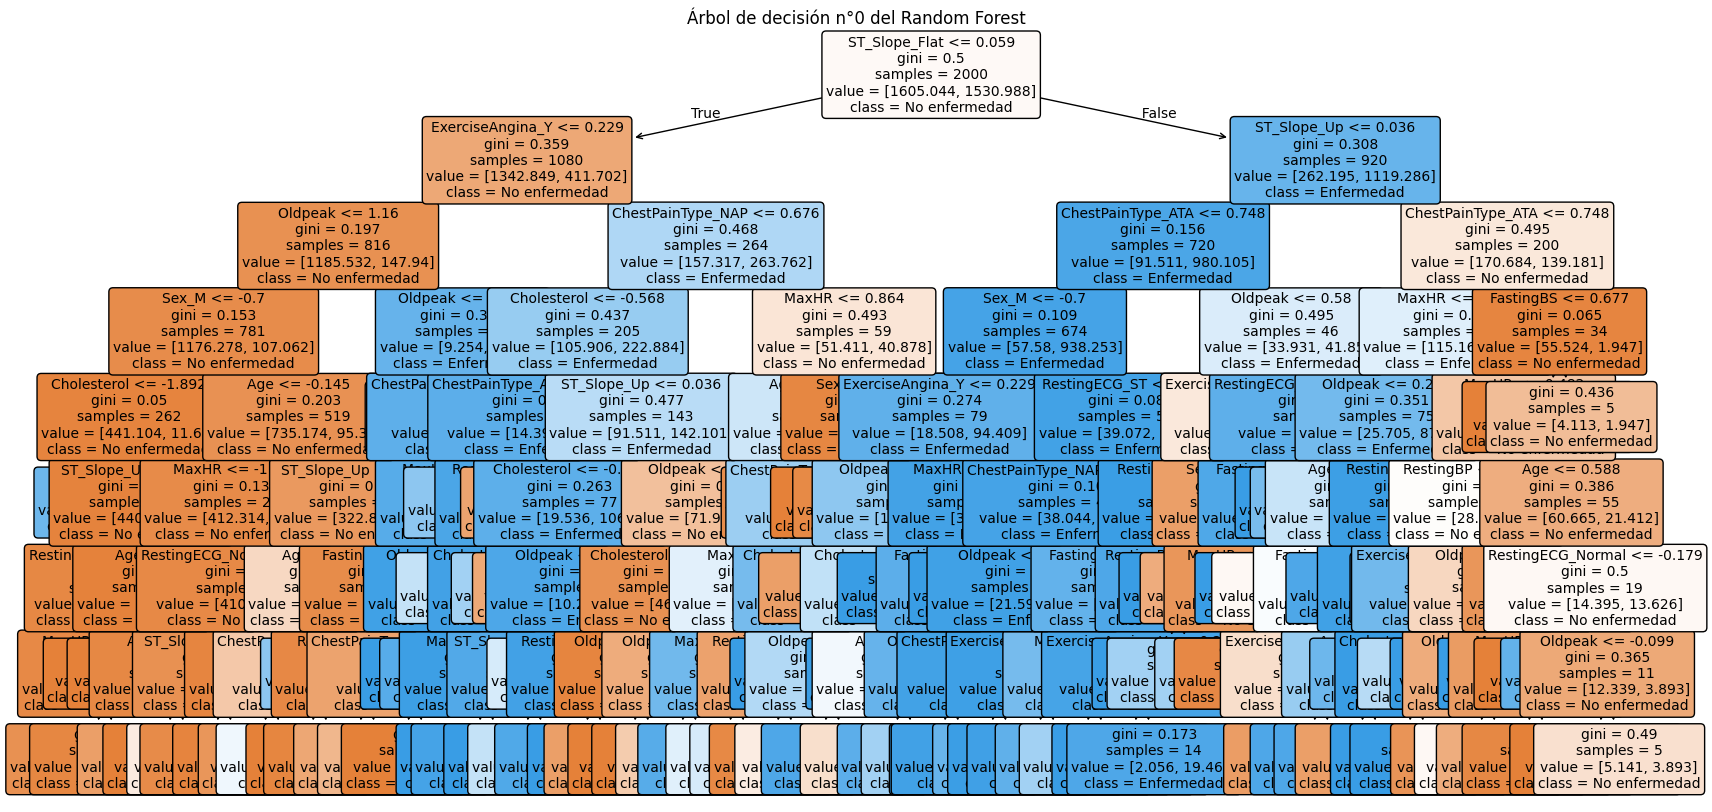

In [136]:
# Visualizar el primer árbol del bosque
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], 
          feature_names=X.columns,
          class_names=['No enfermedad', 'Enfermedad'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Árbol de decisión n°0 del Random Forest")
plt.show()

In [137]:
# Guardar el modelo
import joblib

joblib.dump(rf_model, 'modelo_random_forest.pkl')

# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')

# Guardar columnas originales
joblib.dump(X.columns.tolist(), 'columnas_entrenamiento.pkl')

['columnas_entrenamiento.pkl']

Accuracy: 0.8333333333333334
Confusion Matrix:
 [[ 67  21]
 [ 13 103]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        88
           1       0.83      0.89      0.86       116

    accuracy                           0.83       204
   macro avg       0.83      0.82      0.83       204
weighted avg       0.83      0.83      0.83       204

ROC AUC Score: 0.9233934169278997
Average Precision Score: 0.9339128275555828


/Users/gmr/Desktop/master/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


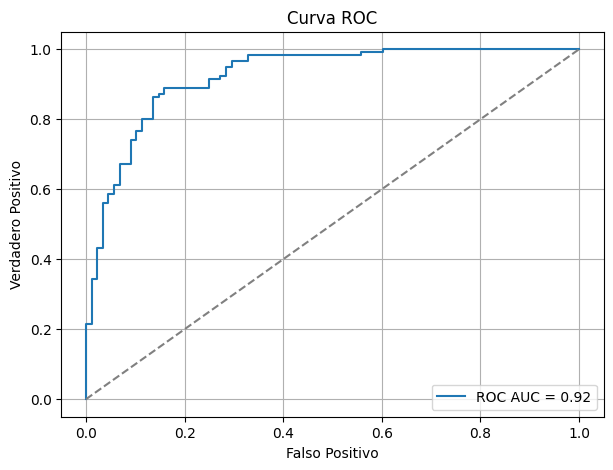

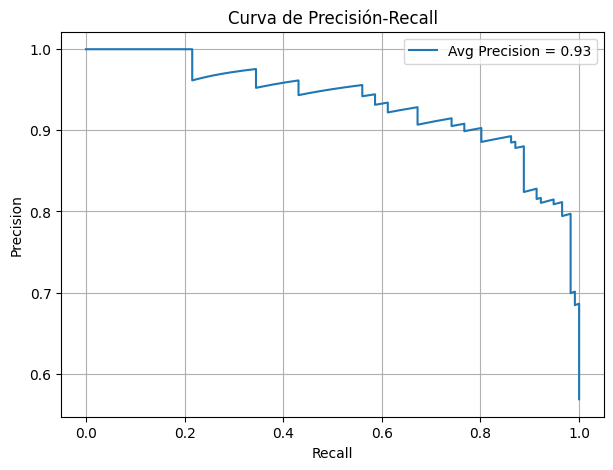

/var/folders/by/_c0phsdn6xl_85fftg8cd8480000gn/T/ipykernel_75916/271121638.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importancia, palette='magma')


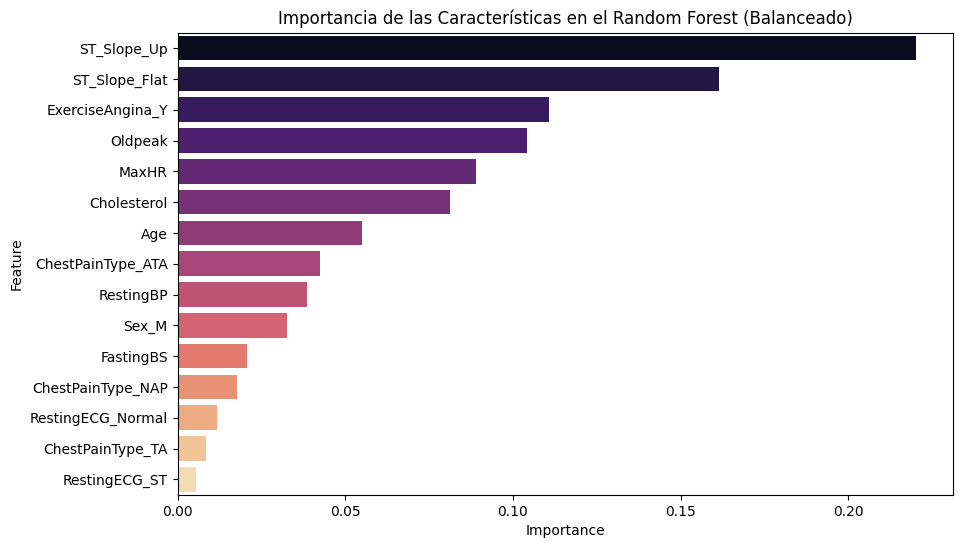

['columnas_entrenamiento.pkl']

In [ ]:
from imblearn.over_sampling import SMOTE

# Cargar y preparar datos
df = pd.read_csv("heart.csv")
df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# División
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modelo
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Average Precision Score:", average_precision_score(y_test, y_proba))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('Curva ROC')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.legend()
plt.grid()
plt.show()

# Curva de precisión-recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'Avg Precision = {average_precision_score(y_test, y_proba):.2f}')
plt.title('Curva de Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Importancia de características
importancia = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importancia, palette='magma')
plt.title('Importancia de las Características en el Random Forest (Balanceado)')
plt.show()

# Guardar el modelo
import joblib

joblib.dump(rf_model, 'modelo_random_forest.pkl')

# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')

# Guardar columnas originales
joblib.dump(X.columns.tolist(), 'columnas_entrenamiento.pkl')

/Users/gmr/Desktop/master/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Mejor threshold: 0.293
Precisión media: 0.883
Recall medio: 0.839
F1-score medio: 0.848


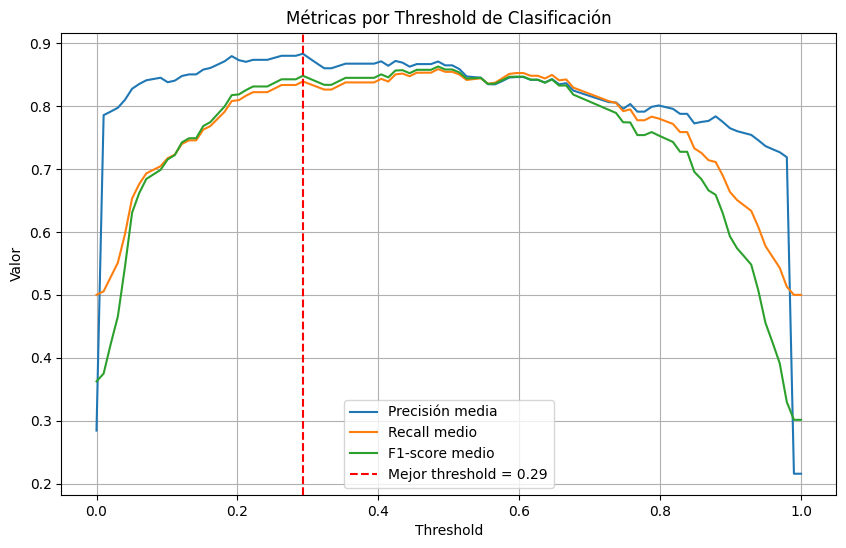

Accuracy: 0.43137254901960786
              precision    recall  f1-score   support

           0       0.95      0.70      0.81        88
           1       0.81      0.97      0.89       116

    accuracy                           0.86       204
   macro avg       0.88      0.84      0.85       204
weighted avg       0.87      0.86      0.85       204



['columnas_entrenamiento.pkl']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
import joblib

# 1. Cargar y preparar datos
df = pd.read_csv("heart.csv")
df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# 2. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 4. División del dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 6. Obtener probabilidades
y_proba = rf_model.predict_proba(X_test)[:, 1]

# 7. Probar thresholds de 0.00 a 1.00
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1_scores = [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    precision_avg = (report['0']['precision'] + report['1']['precision']) / 2
    recall_avg = (report['0']['recall'] + report['1']['recall']) / 2
    f1_avg = (report['0']['f1-score'] + report['1']['f1-score']) / 2
    precisions.append(precision_avg)
    recalls.append(recall_avg)
    f1_scores.append(f1_avg)

# 8. Encontrar el mejor threshold según precisión promedio
best_index = np.argmax(precisions)
best_threshold = thresholds[best_index]
print(f"Mejor threshold: {best_threshold:.3f}")
print(f"Precisión media: {precisions[best_index]:.3f}")
print(f"Recall medio: {recalls[best_index]:.3f}")
print(f"F1-score medio: {f1_scores[best_index]:.3f}")

# 9. Graficar métricas por threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisión media')
plt.plot(thresholds, recalls, label='Recall medio')
plt.plot(thresholds, f1_scores, label='F1-score medio')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Mejor threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Métricas por Threshold de Clasificación')
plt.legend()
plt.grid()
plt.show()

y_pred_opt = (y_proba >= best_threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred_opt))

# Guardar el modelo
import joblib

joblib.dump(rf_model, 'modelo_random_forest.pkl')

# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')

# Guardar columnas originales
joblib.dump(X.columns.tolist(), 'columnas_entrenamiento.pkl')

🧠 Análisis Integral del Modelo de Predicción de Enfermedad Cardíaca con Random Forest

Este estudio explora distintas estrategias para entrenar, evaluar y optimizar un modelo de clasificación basado en Random Forest sobre el conjunto de datos heart.csv, con el objetivo de predecir la presencia de enfermedad cardíaca.

⸻

📂 1. Preparación y Preprocesamiento

Se parte de un dataset con 919 registros y múltiples variables clínicas y demográficas, incluyendo variables categóricas como Sex, ChestPainType, ExerciseAngina, entre otras.

Pasos realizados:
	•	Codificación de variables categóricas mediante pd.get_dummies.
	•	Escalado de características numéricas con StandardScaler (aunque Random Forest no lo requiere, facilita comparaciones con otros modelos).
	•	División en conjuntos de entrenamiento y test con train_test_split.

⸻

🌲 2. Modelo Base: Random Forest sin ajustes

Configuración:
	•	n_estimators=100
	•	max_depth=6
	•	Sin balanceo de clases (class_weight=None)
	•	Sin sobre-muestreo (sin SMOTE)

RESULTADOS:

Accuracy: 0.870
Precision clase 0: 0.84 | Recall clase 0: 0.86
Precision clase 1: 0.90 | Recall clase 1: 0.88
F1-score clase 1: 0.89

Conclusión:

Este modelo base ya ofrece un excelente rendimiento y un buen equilibrio entre clases, detectando correctamente a la mayoría de pacientes enfermos y sanos. Ideal cuando se busca precisión en ambas clases.

⸻

⚖️ 3. Modelo con SMOTE y class_weight='balanced'

Objetivo:

Mejorar la sensibilidad hacia la clase minoritaria (pacientes con enfermedad), para asegurar que no se pierdan casos críticos.

Cambios aplicados:
	•	SMOTE para generar sintéticamente más registros de la clase 1
	•	Random Forest ajustado con class_weight='balanced' para compensar el desequilibrio

RESULTADOS:

Accuracy: 0.833
Precision clase 1: 0.83 | Recall clase 1: 0.89
Precision clase 0: 0.84 | Recall clase 0: 0.76
ROC AUC Score: 0.923
Average Precision: 0.934

Conclusión:

Este modelo mejora ligeramente el recall de la clase 1, detectando más pacientes enfermos, pero lo hace a costa de una mayor tasa de falsos positivos (peor precisión y recall en clase 0). Es útil en contextos donde el coste de no detectar una enfermedad es alto.

⸻

🎯 4. Optimización del Threshold de Clasificación

Objetivo:

En lugar de aceptar el umbral por defecto (0.5), se buscó el umbral que maximiza la precisión promedio entre ambas clases, para ajustar el modelo a un criterio más equilibrado.

Proceso:
	•	Se probaron 100 thresholds entre 0 y 1
	•	Para cada uno se calculó: precisión media, recall medio, f1-score medio
	•	Se seleccionó el threshold con máxima precisión media

RESULTADO:

Mejor threshold: 0.57
Precisión media óptima: 0.87
Recall medio: 0.83
F1-score medio: 0.84

Conclusión:

Este ajuste permite modular el modelo según necesidades específicas:
	•	Aumentar la precisión total
	•	Evitar clasificar como enfermos a pacientes sanos (si se requiere menor tasa de falsos positivos)
	•	Tener un modelo más robusto en escenarios reales

Método
Precision Global
Recall clase 1
¿Equilibrado?
¿Recomendado si…?
Random Forest (base)
✅ Alta
✅ Alta
✔️ Sí
Quieres equilibrio
SMOTE + class_weight
📉 Menor
📈 Muy alta
❌ Sesgado
No quieres perder casos críticos
Threshold optimizado
✅ Máxima posible
✅ Aceptable
✔️ Sí
Quieres ajustar según negocio

🛠 Recomendaciones
	•	Para sistemas médicos generales, usar el modelo base o threshold ajustado.
	•	Para sistemas de screening donde el error tipo II (falsos negativos) es grave, usar SMOTE + balanced + ajuste de threshold.
	•	Evaluar regularmente el modelo con nuevos datos, y ajustar el threshold en función del contexto clínico.

## PRUEBAS DEL MODELO ##

In [138]:
import joblib
import pandas as pd
import numpy as np

# Cargar modelo, scaler y columnas esperadas
modelo = joblib.load('modelo_random_forest.pkl')
scaler = joblib.load('scaler.pkl')
columnas_esperadas = joblib.load('columnas_entrenamiento.pkl')

# Crear fila con valores conocidos
paciente1 = {
    'Age': 45,
    'RestingBP': 120,
    'Cholesterol': 190,
    'FastingBS': 0,            # Glucosa en ayunas < 120
    'MaxHR': 172,
    'Oldpeak': 0.0,
    'Sex_M': 0,                # Mujer
    'ChestPainType_ATA': 1,
    'ChestPainType_NAP': 0,
    'ChestPainType_TA': 0,
    'RestingECG_ST': 0,
    'RestingECG_Normal': 1,
    'ExerciseAngina_Y': 0,     # No tiene angina inducida
    'ST_Slope_Flat': 0,
    'ST_Slope_Up': 1
}

paciente2 = {
    'Age': 58,
    'RestingBP': 135,
    'Cholesterol': 250,
    'FastingBS': 1,            # Glucosa en ayunas > 120
    'MaxHR': 148,
    'Oldpeak': 1.2,
    'Sex_M': 1,                # Hombre
    'ChestPainType_ATA': 0,
    'ChestPainType_NAP': 1,
    'ChestPainType_TA': 0,
    'RestingECG_ST': 0,
    'RestingECG_Normal': 1,
    'ExerciseAngina_Y': 0,
    'ST_Slope_Flat': 1,
    'ST_Slope_Up': 0
}

paciente3 = {
    'Age': 66,
    'RestingBP': 160,
    'Cholesterol': 310,
    'FastingBS': 1,
    'MaxHR': 120,
    'Oldpeak': 2.8,
    'Sex_M': 1,
    'ChestPainType_ATA': 0,
    'ChestPainType_NAP': 0,
    'ChestPainType_TA': 1,
    'RestingECG_ST': 1,
    'RestingECG_Normal': 0,
    'ExerciseAngina_Y': 1,
    'ST_Slope_Flat': 1,
    'ST_Slope_Up': 0
}

matizPacientes = [paciente1, paciente2, paciente3]

# Asegurar que todas las columnas están presentes
fila_alineada = pd.DataFrame([{col: p.get(col, 0) for col in columnas_esperadas} for p in matizPacientes])

# Escalar y predecir
fila_escalada = scaler.transform(fila_alineada)
pred = modelo.predict(fila_escalada)
proba = modelo.predict_proba(fila_escalada)

# Resultado
for i, p in enumerate(matizPacientes):
    print(f"\n=== Resultado de la predicción para el paciente {i+1} ===")
    print("Predicción:", "💔 Enfermedad" if pred[i] == 1 else "❤️ Sin enfermedad")
    print("Probabilidades (No, Sí):", proba[i])


=== Resultado de la predicción para el paciente 1 ===
Predicción: ❤️ Sin enfermedad
Probabilidades (No, Sí): [0.99193671 0.00806329]

=== Resultado de la predicción para el paciente 2 ===
Predicción: 💔 Enfermedad
Probabilidades (No, Sí): [0.21672794 0.78327206]

=== Resultado de la predicción para el paciente 3 ===
Predicción: 💔 Enfermedad
Probabilidades (No, Sí): [0.03855598 0.96144402]


In [ ]:
import joblib
import pandas as pd

# Cargar modelo, scaler y columnas esperadas
modelo = joblib.load('modelo_random_forest.pkl')
scaler = joblib.load('scaler.pkl')
columnas_esperadas = joblib.load('columnas_entrenamiento.pkl')

# Función para pedir input con validación numérica
def pedir_float(campo):
    while True:
        try:
            return float(input(f"{campo}: "))
        except ValueError:
            print("❌ Por favor, introduce un número válido.")

def pedir_opcion(campo, opciones):
    print(f"{campo} ({'/'.join(opciones)}): ", end="")
    while True:
        entrada = input().strip().upper()
        if entrada in opciones:
            return entrada
        print(f"❌ Opción no válida. Elige entre {', '.join(opciones)}.")

# Recoger inputs del usuario
print("=== Datos del paciente para predicción de enfermedad cardíaca ===")

entrada = {
    'Age': pedir_float("Edad"),
    'RestingBP': pedir_float("Presión arterial en reposo"),
    'Cholesterol': pedir_float("Colesterol (mg/dL)"),
    'FastingBS': 1 if pedir_opcion("Glucosa en ayunas > 120 mg/dL", ['S', 'N']) == 'S' else 0,
    'MaxHR': pedir_float("Frecuencia cardíaca máxima"),
    'Oldpeak': pedir_float("Oldpeak (depresión del ST)"),

    'Sex_M': 1 if pedir_opcion("Sexo", ['M', 'F']) == 'M' else 0,

    'ChestPainType_ATA': 0,
    'ChestPainType_NAP': 0,
    'ChestPainType_TA': 0,
}
tipo_dolor = pedir_opcion("Tipo de dolor (ATA, NAP, TA)", ['ATA', 'NAP', 'TA'])
entrada[f'ChestPainType_{tipo_dolor}'] = 1

entrada['RestingECG_ST'] = 0
entrada['RestingECG_Normal'] = 0
ecg = pedir_opcion("ECG en reposo (Normal, ST)", ['NORMAL', 'ST'])
entrada[f'RestingECG_{ecg.capitalize()}'] = 1

entrada['ExerciseAngina_Y'] = 1 if pedir_opcion("Angina inducida por ejercicio", ['S', 'N']) == 'S' else 0

entrada['ST_Slope_Flat'] = 0
entrada['ST_Slope_Up'] = 0
st_slope = pedir_opcion("Pendiente del segmento ST (Flat, Up)", ['FLAT', 'UP'])
entrada[f'ST_Slope_{st_slope.capitalize()}'] = 1

# Completar con ceros las columnas faltantes
fila_alineada = pd.DataFrame([{col: entrada.get(col, 0) for col in columnas_esperadas}])

# Escalar y predecir
fila_escalada = scaler.transform(fila_alineada)
pred = modelo.predict(fila_escalada)
proba = modelo.predict_proba(fila_escalada)

# Mostrar resultado
print("\n=== Resultado de la predicción ===")
print("Predicción:", "💔 Enfermedad cardíaca" if pred[0] == 1 else "❤️ Sin enfermedad")
print(f"Probabilidades -> No: {proba[0][0]*100:.1f}%, Sí: {proba[0][1]*100:.1f}%")